<a href="https://colab.research.google.com/github/FireStrings/MasterDegree/blob/main/xLSTM_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xlstm
!pip install mlstm_kernels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

_dir = "/content/drive/My Drive/UFSCAR/Notebooks"

import os
os.chdir(_dir)

Mounted at /content/drive/


In [ ]:
%run UtilsNew.ipynb

In [ ]:
anual_df = load_and_filter("teresina", 7, 18).set_index("data_hora")

In [ ]:
split = int(0.7 * len(anual_df))
anual_df.iloc[:split].tail()

,data,temp_ins_c,temp_max_c,temp_min_c,umi_ins_perc,umi_max_perc,umi_min_perc,pto_orvalho_ins_c,pto_orvalho_max_c,pto_orvalho_min_c,...,vel_vento_ms,dir_vento_ms,raj_vento_ms,radiacao,chuva_mm,data_str,hora,dia,mes,ano
data_hora,,,,,,,,,,,,,,,,,,,,,
2024-03-14 14:00:00-03:00,2024-03-14,31.4,32.9,31.3,63.0,69.0,57.0,23.5,25.3,22.8,...,0.9,87.0,5.5,1431.6,0.0,2024-03-14,14,14,3,2024
2024-03-14 15:00:00-03:00,2024-03-14,33.7,33.7,31.4,52.0,66.0,49.0,22.6,24.7,21.0,...,1.0,63.0,2.1,1752.5,0.0,2024-03-14,15,14,3,2024
2024-03-14 16:00:00-03:00,2024-03-14,32.4,33.9,32.4,61.0,63.0,46.0,23.8,24.6,20.4,...,1.1,46.0,2.9,1064.6,0.0,2024-03-14,16,14,3,2024
2024-03-14 17:00:00-03:00,2024-03-14,28.5,32.4,28.5,82.0,82.0,60.0,25.2,25.8,23.6,...,2.6,116.0,7.7,227.9,0.6,2024-03-14,17,14,3,2024
2024-03-14 18:00:00-03:00,2024-03-14,27.6,28.5,27.6,90.0,90.0,82.0,25.8,26.1,25.3,...,0.4,277.0,5.4,17.3,0.2,2024-03-14,18,14,3,2024


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from xlstm import (
    xLSTMBlockStack,
    xLSTMBlockStackConfig,
    sLSTMBlockConfig, sLSTMLayerConfig,
    FeedForwardConfig
)

# ============================================
# 1. Dados sintéticos (temperatura diária)
# ============================================
# np.random.seed(42)
dias = 365*2
t = np.arange(dias)
# temperatura = 20 + 10 * np.sin(2 * np.pi * t / 365) + np.random.normal(0, 1, dias)
temperatura = anual_df["radiacao"].values

# Normalização
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(temperatura.reshape(-1, 1))
data_scaled = temperatura.reshape(-1, 1)/1000

# print(data_scaled.shape)
# print(1/0)

# ============================================
# 2. Criar janelas (X, y)
# ============================================
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window_size = 11
X, y = create_sequences(data_scaled, window_size)

# Divisão treino/teste
split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Tensores
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# ============================================
# 3. Configuração do xLSTM (CPU)
# ============================================
embedding_dim = 64

cfg = xLSTMBlockStackConfig(
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="vanilla",   # força CPU
            num_heads=8,
            conv1d_kernel_size=11
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu")
    ),
    context_length=window_size,
    num_blocks=1,
    embedding_dim=embedding_dim,
    slstm_at=[0],
)

xlstm_stack = xLSTMBlockStack(cfg)

# ============================================
# 4. Modelo final
# ============================================
class ForecastModel(nn.Module):
    def __init__(self, xlstm_stack, embedding_dim):
        super().__init__()
        self.input_proj = nn.Linear(1, embedding_dim)  # 1 -> embedding
        self.xlstm = xlstm_stack
        self.head = nn.Linear(embedding_dim, 1)

    def forward(self, x):
        x = self.input_proj(x)          # (batch, seq, emb)
        out = self.xlstm(x)             # (batch, seq, emb)
        last = out[:, -1, :]            # pega último passo
        return self.head(last)

model = ForecastModel(xlstm_stack, embedding_dim)

# ============================================
# 5. Treino
# ============================================
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    out = model(X_train)
    loss = loss_fn(out.squeeze(), y_train.squeeze())
    loss.backward()
    optimizer.step()
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

# ============================================
# 6. Avaliação
# ============================================
model.eval()
with torch.no_grad():
    preds = model(X_test).numpy()

# Inverte escala
# y_test_rescaled = scaler.inverse_transform(y_test.numpy())
# preds_rescaled = scaler.inverse_transform(preds)

y_test_rescaled = y_test.numpy()
preds_rescaled = preds

# plt.figure(figsize=(10,5))
# plt.plot(y_test_rescaled[2000:], label="Real")
# plt.plot(preds_rescaled[2000:], label="Previsto")
# plt.legend()
# plt.show()


Epoch 5, Loss: 0.611408
Epoch 10, Loss: 0.465771
Epoch 15, Loss: 0.302261
Epoch 20, Loss: 0.301072
Epoch 25, Loss: 0.234012
Epoch 30, Loss: 0.243385
Epoch 35, Loss: 0.225717
Epoch 40, Loss: 0.224271
Epoch 45, Loss: 0.217397
Epoch 50, Loss: 0.216813


In [ ]:
def get_results(preds_rescaled, y_test_rescaled, anual_df, show_plot=True):

    period = anual_df[preds_rescaled.shape[0]:]['data'].iloc[:y_test_rescaled.shape[0]]

    if show_plot:
      plot_results_2(preds_rescaled.reshape(preds_rescaled.shape[0]), y_test_rescaled, period)

    return get_metrics(preds_rescaled, y_test_rescaled)

{'mse': 0.2003505676984787,
 'rmse': 0.4476053704978066,
 'mae': 0.38102561235427856,
 'r2': 0.5817785859107971}

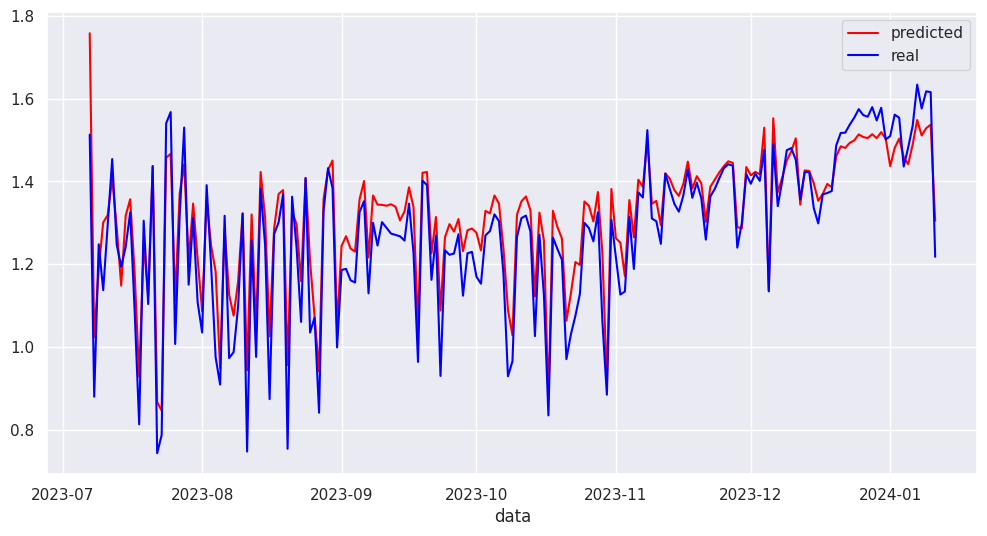

In [ ]:
get_results(preds_rescaled, y_test_rescaled, anual_df, show_plot=True)